In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from quetzal.io import excel

# Logit model step
## Needs LoS tables and calibration parameters
## Saves logit probabilities and utilities

In [3]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load parameters for settings
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
sm = stepmodel.read_json(model_path + 'de_pt_los')
car = stepmodel.read_json(model_path + 'de_road_los')

In [6]:
# Scale time to hours
if sm.pt_los['time'].mean() > 3600:
    sm.pt_los['time'] = sm.pt_los['time'] / 3600
elif sm.pt_los['time'].mean() < 10/3600:
    sm.pt_los['time'] = sm.pt_los['time'] * 3600
sm.pt_los['time'].mean()

5.856105278913301

In [7]:
if car.car_los['time'].mean() > 3600:
    car.car_los['time'] = car.car_los['time'] / 3600
car.car_los['time'].mean()

4.143878616539014

In [8]:
# Define route types for the choice tree
route_types = ['rail',#'rail_long', 'rail_short',
               'bus',#'coach', 'bus',
               'air','car', 'walk']

In [9]:
sm.pt_los['route_type'].unique()

array(['bus', 'rail', 'air', 'walk'], dtype=object)

In [10]:
# Aggregate route types rail and road PT
type_dict = {'rail_long': 'rail', 'rail_short': 'rail', 'rail': 'rail',
             'coach': 'bus', 'bus': 'bus',
             'air': 'air', 'car': 'car', 'walk': 'walk'}
assert set(route_types).issubset(set(type_dict.keys()))
if 'rail_short' in sm.pt_los['route_type']:
    sm.pt_los['route_type_network'] = sm.pt_los['route_type'].copy()
sm.pt_los['route_type'] = sm.pt_los['route_type'].map(type_dict)

In [11]:
sm.pt_los.sample()

,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,...,"('business_no_car', 'probability')","('business_car', 'probability')","('education_no_car', 'probability')","('education_car', 'probability')","('buy/execute_no_car', 'probability')","('buy/execute_car', 'probability')","('leisure_no_car', 'probability')","('leisure_car', 'probability')","('accompany_no_car', 'probability')","('accompany_car', 'probability')"
index,,,,,,,,,,,,,,,,,,,,,
53705,DE144,DE25A,"[bus, coach]","[c_2291, c_2292, c_2293, bus_1760639, bus_1760...",5,223302,1688,324,13040,3822,...,0.086831,0.007162,0.473501,0.188882,0.252855,0.009336,0.177563,0.020535,0.023682,0.002255


In [14]:
# Create LoS table
sm.los = pd.concat([sm.pt_los, car.car_los])
sm.los.reset_index(drop=True, inplace=True)
len(sm.los)

713061

In [15]:
# Make route types hashable
sm.los['route_types'] = sm.los['route_types'].apply(tuple)

In [14]:
# Drop columns from previous logit model runs
sm.los.drop([col for col in sm.los.columns if col.startswith('(')],
            axis=1, inplace=True, errors='ignore')

In [15]:
# Clean LoS table
sm.los = sm.los.loc[sm.los['time']>0]
sm.los = sm.los.loc[sm.los['length']<=1000000]
len(sm.los)

713061

## Prepare the logit model

Load parameters and generate LoS columns

In [12]:
# Transport demand segments
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]

In [13]:
# Load estimation results
excel = pd.ExcelFile(input_path + 'estimation_results.xls')
params_est = {}
for s in segments: # First two sheets are all purposes
    df = excel.parse(s.replace('/', '-'))
    params_est[s] = df.set_index(df.columns[0])

In [16]:
# The nested logit structure can be set for each segment
# It must be the same as in the estimation
segs = segments + ['root']
col = ['root']*len(route_types) + [np.nan] #['pt']*(len(route_types)-3) + ['root']*4 + [np.nan]
nests = pd.DataFrame(index=route_types+['root'], #['pt', 'root'],
                     data={s: col for s in segments})
nests.index.name = 'route_type'
nests.columns.name = 'segment'
sm.mode_nests = nests
sm.mode_nests

segment,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
route_type,,,,,,,,,,,,
rail,root,root,root,root,root,root,root,root,root,root,root,root
bus,root,root,root,root,root,root,root,root,root,root,root,root
air,root,root,root,root,root,root,root,root,root,root,root,root
car,root,root,root,root,root,root,root,root,root,root,root,root
walk,root,root,root,root,root,root,root,root,root,root,root,root
root,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# phi/theta values for each mode and nest come from calibration data
sm.logit_scales = pd.DataFrame(index=route_types, data={seg: 1 for seg in segments})
sm.logit_scales.loc['root'] = [1 for i in range(len(segments))]
# For the nested structure
#sm.logit_scales.loc['pt'] = [1 / params_est[i].loc['mu_pt', 'Value']
#                             for i in range(len(segments))]
sm.logit_scales

,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
rail,1,1,1,1,1,1,1,1,1,1,1,1
bus,1,1,1,1,1,1,1,1,1,1,1,1
air,1,1,1,1,1,1,1,1,1,1,1,1
car,1,1,1,1,1,1,1,1,1,1,1,1
walk,1,1,1,1,1,1,1,1,1,1,1,1
root,1,1,1,1,1,1,1,1,1,1,1,1


In [18]:
# Initial values are the alternative specific constants (ASC) from calibration
sm.mode_utility = pd.DataFrame({seg: [] for seg in segments})
for t, asc in [('rail', 'asc_rail'),
#               ('rail_short', 'asc_rail_s'),
#               ('rail_long', 'asc_rail_l'),
#               ('coach', 'asc_coach'),
               ('bus', 'asc_road'),
               ('air', 'asc_air'), ('car', 0),
               ('walk', 'asc_non_motor'),('root', 0)]:
    sm.mode_utility.loc[t] = [params_est[s].loc[asc, 'Value']
                              if isinstance(asc, str) else asc
                              for s in segments]
sm.mode_utility

,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
rail,2.886830,-1.635993,4.037130,-2.736179,3.066565,-0.131210,0.747413,-2.617346,2.615004,-2.393297,5.466458,-3.647866
bus,1.747406,-3.142805,3.376460,-3.239896,3.541065,-0.156875,-0.083779,-3.210102,1.460974,-2.825168,1.143246,-4.980613
air,-4.083244,-5.825536,-6.951504,-8.765463,-6.161460,-5.011007,0.279204,-0.921647,-3.970609,-1.213549,-0.876716,-6.732983
car,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
walk,-1.048262,-5.142717,-0.575651,-4.294161,-0.428469,-2.768192,-1.015147,-3.555973,-0.115892,-3.397282,-6.896067,-5.235238
root,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
# Performance attributes for mode choice
perf_attrs = [s+'_time' for s in segments] + [s+'_price' for s in segments]

In [20]:
# Beta parameters from calibration data
# IMPORTANT: mind the unit conversion
sm.utility_values = pd.DataFrame({s: [0 for _ in perf_attrs] for s in segments},
                                 index=[str(a) for a in perf_attrs])
#sm.utility_values.loc['waiting_time'] = [params_est[seg].loc['b_wt', 'Value'] for seg in segments]
sm.utility_values.loc['mode_utility'] = [1 for seg in segments]
for s in segments:
    sm.utility_values.loc[s+'_time', s] = params_est[s].loc['b_t', 'Value']
    sm.utility_values.loc[s+'_price', s] = params_est[s].loc['b_c', 'Value']
sm.utility_values

,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
commuting_no_car_time,-0.010969,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
commuting_car_time,0.000000,-0.029324,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
business_no_car_time,0.000000,0.000000,-0.016785,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
business_car_time,0.000000,0.000000,0.000000,-0.02593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
education_no_car_time,0.000000,0.000000,0.000000,0.00000,-0.265943,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
education_car_time,0.000000,0.000000,0.000000,0.00000,0.000000,-0.059333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
buy/execute_no_car_time,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-0.020953,0.000000,0.000000,0.000000,0.000000,0.000000
buy/execute_car_time,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-0.100847,0.000000,0.000000,0.000000,0.000000
leisure_no_car_time,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.025012,0.000000,0.000000,0.000000
leisure_car_time,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.023156,0.000000,0.000000


In [23]:
# Generate damped cost (see cal20)
c = params['estimation'].to_dict()
def spline(x, beta, c1, c2, Q=3):
    alpha = [0, -beta/2*np.power(np.log(c1),3),
             -beta/2*np.log(c1)*(3*np.power(np.log(c2),2)+np.power(np.log(c1),2))] # for Q=3
    theta = [1, 3/2*np.log(c1), 3*np.log(c1)*np.log(c2)] # for Q=3
    return (beta*theta[0]*np.power(np.log(x),Q-1+1) + alpha[0]) * (x<c1) \
    + (beta*theta[1]*np.power(np.log(x),Q-2+1) + alpha[1]) * (x>=c1)*(x<c2) \
    + (beta*theta[2]*np.power(np.log(x),Q-3+1) + alpha[2]) * (x>=c2)

In [24]:
# Apply the spline function
for s in segments:
#    for a in perf_attrs:
#        sm.los[a] = [spline(gc, beta) for gc in sm.los[(s, 'gc')]]
    c1 = c['c1_time_'+s]
    c2 = c['c2_time_'+s]
    beta = sm.utility_values.loc[s+'_time', s]
    sm.los[s+'_time'] = [spline(t*60, beta, c1*60, c2*60) for t in sm.los['time']]

In [22]:
# Make beta_t one because it is now included in the LoS attribute 't'
for s in segments:
    sm.utility_values.loc[s+'_time', s] = 1

## Mode Choice

In [26]:
# Build the utility column in sm.los for each segment
sm.segments = segments
# How defines the mode which ASC is taken: "min" is worst mode in route_types,
# "max" is best, "sum" and "mean"
# Set the main mode as route types to take only this ASC
#sm.los['route_types'] = [(i,) for i in sm.los['route_type']]
sm.analysis_mode_utility(how='main', segment=None)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.69it/s]


In [27]:
# Run the logit model to calculate probabilities
sm.step_logit()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.52s/it]


In [28]:
print(sm.probabilities.shape)
print(sm.utilities.shape)

(1924740, 9)
(1924740, 9)


In [29]:
sm.probabilities.sample(n=3)

route_type,origin,destination,segment,root,walk,car,air,bus,rail
68400,DE278,DE24C,accompany_car,1,0.0,9.868575e-01,0.0,0.001130,0.012012
183399,DEG0E,DE235,business_no_car,1,0.0,9.851311e-03,0.0,0.074690,0.915459
65737,DE262,DEA45,accompany_no_car,1,0.0,4.848098e-12,0.0,0.003664,0.996336


In [30]:
sm.utilities.sample(n=3)

route_type,origin,destination,segment,root,walk,car,air,bus,rail
31996,DE21B,DEA31,buy/execute_car,-8.354264,-inf,-8.367982,-15.520594,-inf,-12.708503
23764,DE133,DEG04,buy/execute_car,-7.093089,-inf,-7.113550,-inf,-11.145571,-12.945017
43665,DE233,DE144,education_no_car,-13.207684,-inf,-30.192316,-inf,-13.428665,-14.825821


In [31]:
sm.los.sample()

,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,...,"(business_no_car, probability)","(business_car, probability)","(education_no_car, probability)","(education_car, probability)","(buy/execute_no_car, probability)","(buy/execute_car, probability)","(leisure_no_car, probability)","(leisure_car, probability)","(accompany_no_car, probability)","(accompany_car, probability)"
25216,DE125,DE402,"(rail_long, rail_short)","[rs_38988, rs_38989, rs_38990, rs_38991, rl_10...",2.0,535607,910,87,18540,2782,...,0.408463,0.059087,0.01197,0.008052,0.082706,0.002426,0.088788,0.009792,0.000046,0.00003


In [32]:
# Validate that probabilities sum up to one
od = sm.los.groupby(['origin', 'destination']).sum()[
    [(seg, 'probability') for seg in sm.segments]].mean(axis=1)
print(od.mean())
print(od.max())
print(od.min())

1.0
1.0000000000000002
0.9999999999999999


## Save model

In [33]:
sm.utilities.reset_index(drop=True, inplace=True)
sm.probabilities.reset_index(drop=True, inplace=True)
sm.to_json(model_path + 'de_logit', only_attributes=[
    'segments', 'mode_nests', 'logit_scales', 'mode_utility',
    'utility_values', 'probabilities', 'utilities'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 38/38 [00:17<00:00,  2.13it/s]


In [40]:
# Save LoS table
if 'route_type_network' in sm.los.columns:
    sm.los['route_type'] = sm.los['route_type_network']
sm.pt_los = sm.los.loc[sm.los['route_type']!='car'].reset_index()
sm.to_json(model_path + 'de_pt_los', only_attributes=['pt_los'],
           encoding='utf-8')
sm.car_los = sm.los.loc[sm.los['route_type']=='car'].reset_index()
sm.to_json(model_path + 'de_road_los', only_attributes=['car_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 39/39 [00:19<00:00,  2.02it/s]


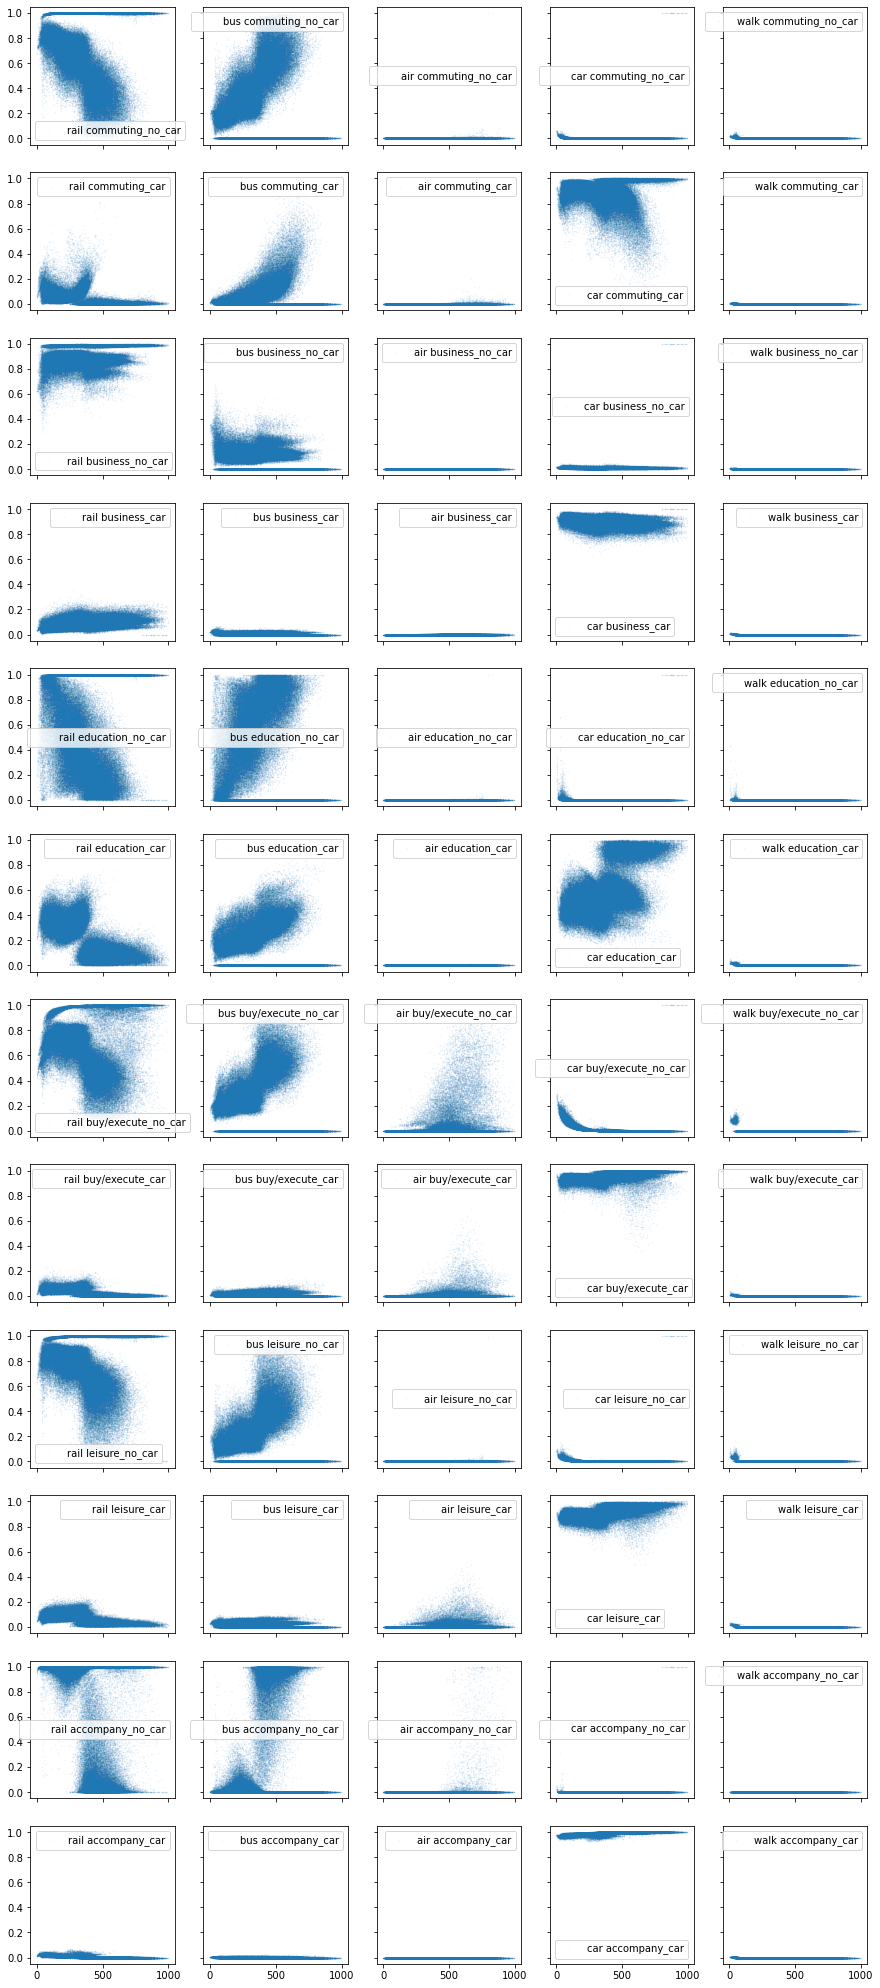

In [41]:
# Distance-distribution of probabilities
if manual:
    merged = sm.probabilities.merge(car.car_los[['origin', 'destination', 'length']],
                                    on=['origin', 'destination'], how='inner')
    fig, ax = plt.subplots(nrows=len(segments), ncols=len(route_types),
                           sharex='all', sharey='all', figsize=(15,len(segments)*3))
    for j, mode in zip(range(len(route_types)), route_types):
        for i, seg in zip(range(len(segments)), segments):
            x = merged.loc[merged['segment']==seg, 'length'] / 1000
            y = merged.loc[merged['segment']==seg, mode]
            ax[i,j].scatter(x, y, marker='o', s=.15, alpha=.1, label=mode+' '+seg)
            #p = np.poly1d(np.polyfit(x, y, deg=3))
            #ax[i,j].plot(x, p(x), linestyle='', marker='o', markersize=.5, color='grey', label=mode+' '+seg)
            ax[i,j].legend()

### Save composite generalised cost / logsum
For sequential destination choice modelling

In [28]:
# define the logsum function with numpy
def logsum(v_list):
    # Given a list of pre-calculated negative utilities
    return np.log(np.sum([np.exp(-1 * v) for v in v_list]))

In [30]:
# Make price utility negative by multiplying with betas (time already is)
for s in segments:
    price_col = s + '_price'
    sm.los[price_col] *= sm.utility_values.loc[price_col, s]

In [38]:
# Calculate composite cost for price and time
comp_cost = sm.los.groupby(['origin', 'destination']).agg(
    {col: logsum for col in perf_attrs})

In [39]:
# Sum up generalised cost
for s in segments:
    attrs = [s+'_time', s+'_price']
    comp_cost[s] = comp_cost[attrs].sum(axis=1)
    comp_cost.drop(attrs, axis=1, inplace=True)

In [40]:
# Save
comp_cost.to_csv(output_path + scenario + '/mode_choice_od_composite_cost.csv')

In [51]:
# Calculate the logsum
comp_u = sm.los.groupby(['origin', 'destination']).agg(
    {str((s, 'utility')): logsum for s in segments})

In [52]:
# Save it
comp_u.columns = [c.split("'")[1] for c in comp_u.columns]
comp_u.to_csv(output_path + scenario + '/mode_choice_od_composite_utility.csv')